# Predicting Boston Housing Prices

## Using XGBoost in SageMaker (Hyperparameter Tuning, _detailed approach_)

_Deep Learning Nanodegree Program | Deployment_

---

As an introduction to using SageMaker's High Level Python API for **hyperparameter tuning**, we will look again at the [Boston Housing Dataset](https://www.cs.toronto.edu/~delve/data/boston/bostonDetail.html) project from before. 

## General Outline

The same steps 1 to 5 are performed but with hyperparameter tuning in step 4 using the _detailed approach_: 

1. Download or otherwise retrieve the data.
2. Process / Prepare the data.
3. Upload the processed data to S3.
4. Train a chosen model **with hyperparameter tuning**
5. Test the trained model (typically using a batch transform job).


### On Hyperparameter tuning with the detailed approach

This looks a lot like the low-level approach, but Creating a hyperparameter tuning job using the low level approach requires us to describe two different things:

- The first, is a training job that will be used as the **base job** for the hyperparameter tuning task. This training job description is almost exactly the same as the standard training job description except that instead of specifying HyperParameters we specify **StaticHyperParameters**. That is, the hyperparameters that we do **not** want to change in the various iterations.
- The second thing we need to describe is the **tuning job** itself. This description includes the different ranges of hyperparameters that we do want SageMaker to vary, in addition to the total number of jobs we want to have created and how to determine which model is best.

## Step 0: Setting up the notebook

In [11]:
%matplotlib inline

import os

import time
from time import strftime, gmtime
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from sklearn.datasets import load_boston
import sklearn.model_selection

In [2]:
import sagemaker
from sagemaker import get_execution_role
from sagemaker.amazon.amazon_estimator import get_image_uri

# This is an object that represents the SageMaker session that we are currently operating in. This
# object contains some useful information that we will need to access later such as our region.
session = sagemaker.Session()

# This is an object that represents the IAM role that we are currently assigned. When we construct
# and launch the training job later we will need to tell it what IAM role it should have. Since our
# use case is relatively simple we will simply assign the training job the role we currently have.
role = get_execution_role()

## Step 1: Downloading the data


In [3]:
boston = load_boston()

## Step 2: Preparing and splitting the data

In [4]:
# First we package up the input data and the target variable (the median value) as pandas dataframes. This
# will make saving the data to a file a little easier later on.

X_bos_pd = pd.DataFrame(boston.data, columns=boston.feature_names)
Y_bos_pd = pd.DataFrame(boston.target)

# We split the dataset into 2/3 training and 1/3 testing sets.
X_train, X_test, Y_train, Y_test = sklearn.model_selection.train_test_split(X_bos_pd, Y_bos_pd, test_size=0.33)

# Then we split the training set further into 2/3 training and 1/3 validation sets.
X_train, X_val, Y_train, Y_val = sklearn.model_selection.train_test_split(X_train, Y_train, test_size=0.33)

## Step 3: Uploading the data files to S3

In [5]:
# This is our local data directory. We need to make sure that it exists.
data_dir = '../data/boston'
if not os.path.exists(data_dir):
    os.makedirs(data_dir)

In [6]:
# We use pandas to save our test, train and validation data to csv files. Note that we make sure not to include header
# information or an index as this is required by the built in algorithms provided by Amazon. Also, for the train and
# validation data, it is assumed that the first entry in each row is the target variable.

X_test.to_csv(os.path.join(data_dir, 'test.csv'), header=False, index=False)

pd.concat([Y_val, X_val], axis=1).to_csv(os.path.join(data_dir, 'validation.csv'), header=False, index=False)
pd.concat([Y_train, X_train], axis=1).to_csv(os.path.join(data_dir, 'train.csv'), header=False, index=False)

In [7]:
prefix = 'boston-xgboost-tuning-LL'

test_location = session.upload_data(os.path.join(data_dir, 'test.csv'), key_prefix=prefix)
val_location = session.upload_data(os.path.join(data_dir, 'validation.csv'), key_prefix=prefix)
train_location = session.upload_data(os.path.join(data_dir, 'train.csv'), key_prefix=prefix)

## Step 4: Train and construct the XGBoost model

Now that we have the training and validation data uploaded to S3, we can construct our XGBoost model and train it. Unlike in the previous notebooks, instead of training a single model, we will use SageMakers hyperparameter tuning functionality to train multiple models and use the one that performs the best on the validation set.

### Set up the training job

First, we will set up a training job for our model. This is very similar to the way in which we constructed the training job in previous notebooks. Essentially this describes the *base* training job from which SageMaker will create refinements by changing some hyperparameters during the hyperparameter tuning job.

In [8]:
# We will need to know the name of the container that we want to use for training. SageMaker provides
# a nice utility method to construct this for us.
container = get_image_uri(session.boto_region_name, 'xgboost')

# We now specify the parameters we wish to use for our training job
training_params = {}

# We need to specify the permissions that this training job will have. For our purposes we can use
# the same permissions that our current SageMaker session has.
training_params['RoleArn'] = role

# Here we describe the algorithm we wish to use. The most important part is the container which
# contains the training code.
training_params['AlgorithmSpecification'] = {
    "TrainingImage": container,
    "TrainingInputMode": "File"
}

# We also need to say where we would like the resulting model artifacts stored.
training_params['OutputDataConfig'] = {
    "S3OutputPath": "s3://" + session.default_bucket() + "/" + prefix + "/output"
}

# We also need to set some parameters for the training job itself. Namely we need to describe what sort of
# compute instance we wish to use along with a stopping condition to handle the case that there is
# some sort of error and the training script doesn't terminate.
training_params['ResourceConfig'] = {
    "InstanceCount": 1,
    "InstanceType": "ml.m4.xlarge",
    "VolumeSizeInGB": 5
}
    
training_params['StoppingCondition'] = {
    "MaxRuntimeInSeconds": 86400
}

# Next we set the algorithm specific hyperparameters. In this case, since we are setting up
# a training job which will serve as the base training job for the eventual hyperparameter
# tuning job, we only specify the _static_ hyperparameters. That is, the hyperparameters that
# we do _not_ want SageMaker to change.
training_params['StaticHyperParameters'] = {
    "gamma": "4",
    "subsample": "0.8",
    "objective": "reg:linear",
    "early_stopping_rounds": "10",
    "num_round": "200"
}

# Now we need to tell SageMaker where the data should be retrieved from.
training_params['InputDataConfig'] = [
    {
        "ChannelName": "train",
        "DataSource": {
            "S3DataSource": {
                "S3DataType": "S3Prefix",
                "S3Uri": train_location,
                "S3DataDistributionType": "FullyReplicated"
            }
        },
        "ContentType": "csv",
        "CompressionType": "None"
    },
    {
        "ChannelName": "validation",
        "DataSource": {
            "S3DataSource": {
                "S3DataType": "S3Prefix",
                "S3Uri": val_location,
                "S3DataDistributionType": "FullyReplicated"
            }
        },
        "ContentType": "csv",
        "CompressionType": "None"
    }
]

	get_image_uri(region, 'xgboost', '0.90-1').


### Set up the tuning job

Now that the *base* training job has been set up, we can describe the tuning job that we would like SageMaker to perform. In particular, like in the high level notebook, we will specify which hyperparameters we wish SageMaker to change and what range of values they may take on.

In addition, we specify the *number* of models to construct (`max_jobs`) and the number of those that can be trained in parallel (`max_parallel_jobs`). In the cell below we have chosen to train `20` models, of which we ask that SageMaker train `3` at a time in parallel. Note that this results in a total of `20` training jobs being executed which can take some time, in this case almost a half hour. With more complicated models this can take even longer so be aware!

In [9]:
# We need to construct a dictionary which specifies the tuning job we want SageMaker to perform
tuning_job_config = {
    # First we specify which hyperparameters we want SageMaker to be able to vary,
    # and we specify the type and range of the hyperparameters.
    "ParameterRanges": {
    "CategoricalParameterRanges": [],
    "ContinuousParameterRanges": [
        {
            "MaxValue": "0.5",
            "MinValue": "0.05",
            "Name": "eta"
        },
    ],
    "IntegerParameterRanges": [
        {
            "MaxValue": "12",
            "MinValue": "3",
            "Name": "max_depth"
        },
        {
            "MaxValue": "8",
            "MinValue": "2",
            "Name": "min_child_weight"
        }
    ]},
    # We also need to specify how many models should be fit and how many can be fit in parallel
    "ResourceLimits": {
        "MaxNumberOfTrainingJobs": 3,  # 20 originally, reduced only for demo 
        "MaxParallelTrainingJobs": 3
    },
    # Here we specify how SageMaker should update the hyperparameters as new models are fit
    "Strategy": "Bayesian",
    # And lastly we need to specify how we'd like to determine which models are better or worse
    "HyperParameterTuningJobObjective": {
        "MetricName": "validation:rmse",
        "Type": "Minimize"
    }
  }

### Execute the tuning job

Now that we've built the data structures that describe the tuning job we want SageMaker to execute, it is time to actually start the job.

In [12]:
# First we need to choose a name for the job. This is useful for if we want to recall information about our
# tuning job at a later date. Note that SageMaker requires a tuning job name and that the name needs to
# be unique, which we accomplish by appending the current timestamp.
tuning_job_name = "tuning-job" + strftime("%Y-%m-%d-%H-%M-%S", gmtime())

# And now we ask SageMaker to create (and execute) the training job
session.sagemaker_client.create_hyper_parameter_tuning_job(HyperParameterTuningJobName = tuning_job_name,
                                                           HyperParameterTuningJobConfig = tuning_job_config,
                                                           TrainingJobDefinition = training_params)

{'HyperParameterTuningJobArn': 'arn:aws:sagemaker:eu-west-1:873674308518:hyper-parameter-tuning-job/tuning-job2019-12-25-21-38-19',
 'ResponseMetadata': {'RequestId': '8fef7167-c71e-4843-9e72-8cd8b1c14eea',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'x-amzn-requestid': '8fef7167-c71e-4843-9e72-8cd8b1c14eea',
   'content-type': 'application/x-amz-json-1.1',
   'content-length': '130',
   'date': 'Wed, 25 Dec 2019 21:38:19 GMT'},
  'RetryAttempts': 0}}

The tuning job has now been created by SageMaker and is currently running. Since we need the output of the tuning job, we may wish to wait until it has finished. We can do so by asking SageMaker to output the logs generated by the tuning job and continue doing so until the job terminates.

In [13]:
session.wait_for_tuning_job(tuning_job_name)

..............................................!


{'HyperParameterTuningJobName': 'tuning-job2019-12-25-21-38-19',
 'HyperParameterTuningJobArn': 'arn:aws:sagemaker:eu-west-1:873674308518:hyper-parameter-tuning-job/tuning-job2019-12-25-21-38-19',
 'HyperParameterTuningJobConfig': {'Strategy': 'Bayesian',
  'HyperParameterTuningJobObjective': {'Type': 'Minimize',
   'MetricName': 'validation:rmse'},
  'ResourceLimits': {'MaxNumberOfTrainingJobs': 3,
   'MaxParallelTrainingJobs': 3},
  'ParameterRanges': {'IntegerParameterRanges': [{'Name': 'max_depth',
     'MinValue': '3',
     'MaxValue': '12',
     'ScalingType': 'Auto'},
    {'Name': 'min_child_weight',
     'MinValue': '2',
     'MaxValue': '8',
     'ScalingType': 'Auto'}],
   'ContinuousParameterRanges': [{'Name': 'eta',
     'MinValue': '0.05',
     'MaxValue': '0.5',
     'ScalingType': 'Auto'}],
   'CategoricalParameterRanges': []}},
 'TrainingJobDefinition': {'StaticHyperParameters': {'_tuning_objective_metric': 'validation:rmse',
   'early_stopping_rounds': '10',
   'gamma'

**Note:** We can see a lot of details and also monitor the actual progress through log info in the Sagemaker console under 'hyperparameter tuning jobs'.

### Build the model

Now that the tuning job has finished, SageMaker has fit a number of models, the results of which are stored in a data structure which we can access using the name of the tuning job.

In [14]:
tuning_job_info = session.sagemaker_client.describe_hyper_parameter_tuning_job(HyperParameterTuningJobName=tuning_job_name)

Among the pieces of information included in the `tuning_job_info` object is the name of the training job which performed best out of all of the models that SageMaker fit to our data. Using this training job name we can get access to the resulting model artifacts, from which we can construct a model.

In [15]:
# We begin by asking SageMaker to describe for us the results of the best training job. The data
# structure returned contains a lot more information than we currently need, try checking it out
# yourself in more detail.
best_training_job_name = tuning_job_info['BestTrainingJob']['TrainingJobName']
training_job_info = session.sagemaker_client.describe_training_job(TrainingJobName=best_training_job_name)

model_artifacts = training_job_info['ModelArtifacts']['S3ModelArtifacts']

In [16]:
# Just like when we created a training job, the model name must be unique
model_name = best_training_job_name + "-model"

# We also need to tell SageMaker which container should be used for inference and where it should
# retrieve the model artifacts from. In our case, the xgboost container that we used for training
# can also be used for inference.
primary_container = {
    "Image": container,
    "ModelDataUrl": model_artifacts
}

# And lastly we construct the SageMaker model
model_info = session.sagemaker_client.create_model(
                                ModelName = model_name,
                                ExecutionRoleArn = role,
                                PrimaryContainer = primary_container)

## Step 5: Testing the model

In [17]:
# Just like in each of the previous steps, we need to make sure to name our job and the name should be unique.
transform_job_name = 'boston-xgboost-batch-transform-' + strftime("%Y-%m-%d-%H-%M-%S", gmtime())

# Now we construct the data structure which will describe the batch transform job.
transform_request = \
{
    "TransformJobName": transform_job_name,
    
    # This is the name of the model that we created earlier.
    "ModelName": model_name,
    
    # This describes how many compute instances should be used at once. If you happen to be doing a very large
    # batch transform job it may be worth running multiple compute instances at once.
    "MaxConcurrentTransforms": 1,
    
    # This says how big each individual request sent to the model should be, at most. One of the things that
    # SageMaker does in the background is to split our data up into chunks so that each chunks stays under
    # this size limit.
    "MaxPayloadInMB": 6,
    
    # Sometimes we may want to send only a single sample to our endpoint at a time, however in this case each of
    # the chunks that we send should contain multiple samples of our input data.
    "BatchStrategy": "MultiRecord",
    
    # This next object describes where the output data should be stored. Some of the more advanced options which
    # we don't cover here also describe how SageMaker should collect output from various batches.
    "TransformOutput": {
        "S3OutputPath": "s3://{}/{}/batch-bransform/".format(session.default_bucket(),prefix)
    },
    
    # Here we describe our input data. Of course, we need to tell SageMaker where on S3 our input data is stored, in
    # addition we need to detail the characteristics of our input data. In particular, since SageMaker may need to
    # split our data up into chunks, it needs to know how the individual samples in our data file appear. In our
    # case each line is its own sample and so we set the split type to 'line'. We also need to tell SageMaker what
    # type of data is being sent, in this case csv, so that it can properly serialize the data.
    "TransformInput": {
        "ContentType": "text/csv",
        "SplitType": "Line",
        "DataSource": {
            "S3DataSource": {
                "S3DataType": "S3Prefix",
                "S3Uri": test_location,
            }
        }
    },
    
    # And lastly we tell SageMaker what sort of compute instance we would like it to use.
    "TransformResources": {
            "InstanceType": "ml.m4.xlarge",
            "InstanceCount": 1
    }
}

In [18]:
transform_response = session.sagemaker_client.create_transform_job(**transform_request)

In [19]:
transform_desc = session.wait_for_transform_job(transform_job_name)

..............................................!


In [20]:
transform_output = "s3://{}/{}/batch-bransform/".format(session.default_bucket(),prefix)

In [21]:
!aws s3 cp --recursive $transform_output $data_dir

download: s3://sagemaker-eu-west-1-873674308518/boston-xgboost-tuning-LL/batch-bransform/test.csv.out to ../data/boston/test.csv.out


In [22]:
Y_pred = pd.read_csv(os.path.join(data_dir, 'test.csv.out'), header=None)

Text(0.5, 1.0, 'Median Price vs Predicted Price')

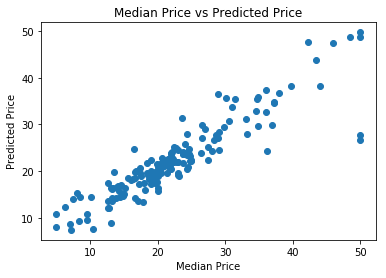

In [23]:
plt.scatter(Y_test, Y_pred)
plt.xlabel("Median Price")
plt.ylabel("Predicted Price")
plt.title("Median Price vs Predicted Price")

## Optional: Clean up

In [24]:
!rm $data_dir/*
!rmdir $data_dir

---